In [1]:
import IPython
from scipy.io import wavfile
import scipy.signal
import contextlib
import sys
import wave
import numpy as np
import matplotlib.pyplot as plt
import librosa
import time
from datetime import timedelta as td

%matplotlib inline

In [2]:
def get_parameters(path):
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()
        pcm_data = wf.readframes(wf.getnframes())
        return num_channels, sample_width, sample_rate, type(pcm_data)

In [3]:
def read_audio(path):
    samprate_audio, audio = wavfile.read(path)
    num_channels, samp_width, samp_rate, type= get_parameters(path)
    if num_channels!=1:
        audio = audio[:,1]
    return samprate_audio, audio

In [4]:
def write_audio(path, output):
    m = np.max(np.abs(output))
    out_32 = (output/m).astype(np.float32)
    wavfile.write(path, int(samprate_audio), out_32)

In [5]:
def generate_noise_sample(noise, length):
    noise_clip = noise[:samprate_noise*length]
    noise_clip = np.asarray(noise_clip, dtype=float)
    return noise_clip

In [6]:
def plot_signals(audio, noise, plot_lim):

    plt.figure(figsize=(14, 14))
    ax1 = plt.subplot(211)
    plt.plot(audio)
    plt.title("Original Signal")
    plt.xlim(plot_lim)

    ax2 = plt.subplot(212)
    plt.plot(noise)
    plt.title("Noise Signal")
    plt.xlim(plot_lim)

In [7]:
def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)
def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)
def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x,ref=1.0)
def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20,4))
    cax = ax.matshow(signal, origin = 'lower', aspect='auto', cmap=plt.cm.seismic, vmin=-1*np.max(np.abs(signal)), vmax=np.max(np.abs(signal)))
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
def plot_statistics_and_filter(mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter):
    fig, ax = plt.subplots(ncols=2, figsize=(20,4))
    plt_mean, = ax[0].plot(mean_freq_noise, label='Mean power of noise')
    plt_std, = ax[0].plot(std_freq_noise, label='Std. power of noise')
    plt_std, = ax[0].plot(noise_thresh, label='Noise threshold (by frequency)')
    ax[0].set_title('Threshold for mask')
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin = 'lower')
    fig.colorbar(cax)
    ax[1].set_title('Filter for smoothing Mask')
    plt.show()
    
def removeNoise(audio_clip, noise_clip, n_grad_freq=2, n_grad_time=4, n_fft=2048, win_length=2048, hop_length=512, n_std_thresh=1.5, prop_decrease=1, verbose=False, visual=False):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose: start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length) 
    noise_stft_db = _amp_to_db(np.abs(noise_stft))# convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis =1)
    std_freq_noise = np.std(noise_stft_db, axis =1)
    noise_thresh = mean_freq_noise+std_freq_noise*n_std_thresh
    if verbose: print('STFT on noise:', td(seconds=time.time()-start)); start = time.time()
    # STFT over signal
    if verbose: start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose: print('STFT on signal:',td(seconds=time.time()-start)); start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(np.concatenate([np.linspace(0,1,n_grad_freq+1,endpoint=False),np.linspace(1,0,n_grad_freq+2)])[1:-1], 
                       np.concatenate([np.linspace(0,1,n_grad_time+1,endpoint=False),np.linspace(1,0,n_grad_time+2)])[1:-1])
    smoothing_filter = smoothing_filter/np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(np.reshape(noise_thresh, [1,len(mean_freq_noise)]), np.shape(sig_stft_db)[1], axis = 0).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db<db_thresh
    if verbose: print('Masking:', td(seconds=time.time()-start)); start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter,  mode='same')
    sig_mask = sig_mask*prop_decrease
    if verbose: print('Mask convolution:', td(seconds=time.time()-start)); start = time.time()
    # mask the signal
    sig_stft_db_masked = sig_stft_db *(1-sig_mask) + np.ones(np.shape(mask_gain_dB))*mask_gain_dB*sig_mask # mask real
    sig_imag_masked = np.imag(sig_stft)*(1-sig_mask)
    sig_stft_amp = ((_db_to_amp(sig_stft_db_masked)*np.sign(sig_stft))+(1j * sig_imag_masked) )
    if verbose: print('Mask application:', td(seconds=time.time()-start)); start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(np.abs(_stft(recovered_signal, n_fft, hop_length, win_length)))
    if verbose: print('Signal recovery:', td(seconds=time.time()-start));
    if visual: plot_spectrogram(noise_stft_db, title='Noise')
    if visual: plot_statistics_and_filter(mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter)
    if visual: plot_spectrogram(sig_stft_db, title='Signal')
    if visual: plot_spectrogram(sig_mask, title='Mask applied')
    if visual: plot_spectrogram(sig_stft_db_masked, title='Masked signal')
    if visual: plot_spectrogram(recovered_spec, title='Recovered spectrogram')
    return recovered_signal

In [8]:
def noise_red(audio, noise_clip, prop_decrease = 0.5, verbose = False, visual = False, fft_size = 4096, iterations = 2):
    output = removeNoise(audio, noise_clip, n_fft = fft_size, win_length = fft_size, prop_decrease = prop_decrease, verbose=False, visual=False)
    iterations = iterations - 1
    while(iterations!=0):
        output = removeNoise(output, noise_clip, n_fft = fft_size, win_length = fft_size, prop_decrease = prop_decrease, verbose=False, visual=False)
        iterations = iterations - 1
    return output

[ 90.304   104.56287 114.04801 ...  42.21553  42.21553  42.21553] 56.28691
[ 90.304   104.56287 114.04801 ...  42.21553  42.21553  42.21553] 55.266357


(250000, 350000)

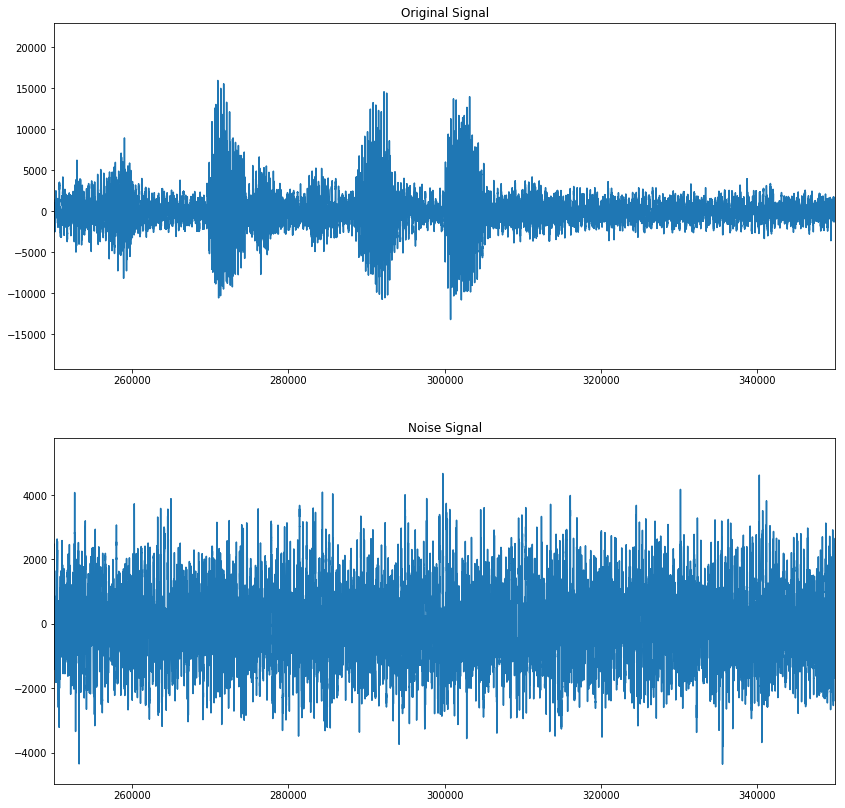

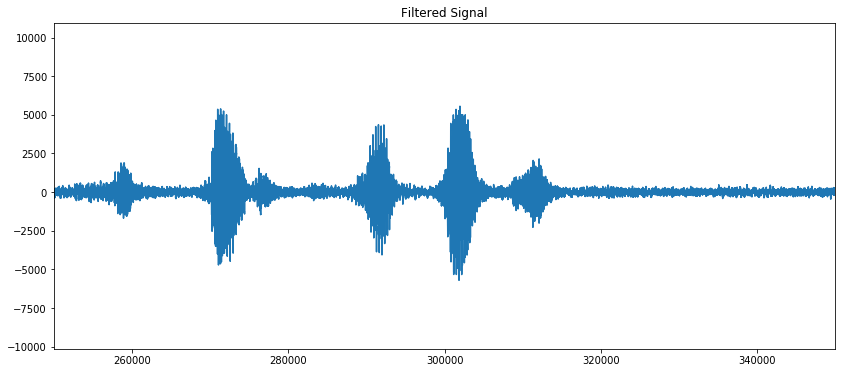

In [9]:
audio_fp = r"C:\Users\LIU181\Desktop\Noise_Reduction(SNG)\Test audio\Samp_3.wav"
noise_fp = r"C:\Users\LIU181\Desktop\Noise_Reduction(SNG)\Test audio\Samp_2.wav"
samprate_audio, audio = read_audio(audio_fp)
samprate_noise, noise = read_audio(noise_fp)

audio = audio.astype(float)
noise_clip = generate_noise_sample(noise, 2)

plot_lim = [250000, 350000]
plot_signals(audio, noise, plot_lim)

output = noise_red(audio, noise_clip, fft_size = 4096, iterations = 2)

plt.figure(figsize=(14, 6))
plt.plot(output)
plt.title("Filtered Signal")
plt.xlim(plot_lim)

In [10]:
print("Original Signal")
IPython.display.Audio(data = audio, rate = samprate_audio)

Original Signal


In [11]:
print("Filtered Signal")
IPython.display.Audio(data = output, rate = samprate_audio)

Filtered Signal
